An implementation of neural style transfer using various Internet resources as reference.
- https://www.youtube.com/watch?v=DEK-W5cxG-g&ab_channel=gaussian37
- https://www.datacamp.com/community/tutorials/implementing-neural-style-transfer-using-tensorflow
- Coursera/Deeplearning.AI Deep Learning course (section on neural style transfer)
- https://iq.opengenus.org/vgg19-architecture/#:~:text=VGG19%20is%20a%20variant%20of,VGG19%20has%2019.6%20billion%20FLOPs.


In [1]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

%matplotlib inline

In [2]:
# check to see if GPU is available
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# define the weighting of each image for the final picture, learning rate; these are the hyperparameters
hparameters = {
    'lr' : 0.01,
    'style_weight' : 50,
    'content_weight' : 10,
    'style_weights' : {
        'block1_conv1' : 0.1,
        'block2_conv1' : 0.3,
        'block3_conv1' : 0.5,
        'block4_conv1' : 1.0,
        'block5_conv1' : 0.8
    },
    'epochs' : 18,
    'steps_per_epoch' : 500
}

In [4]:
def import_image(filepath):
    """
    Helper function to import the style and content images and convert them into tensors.

    Arguments:
    - filepath: location of the style or content image

    Returns the image as a tensor of dimensions (1, height, width, 3).
    """
    # import style and content images
    image = plt.imread(filepath)

    converted = tf.image.convert_image_dtype(image,tf.float32)
    converted = tf.image.resize(converted, [400, 400])
    converted = converted[tf.newaxis, :]
    
    return converted

In [5]:
# filepaths for style and content images
style = import_image('style.jpg')
content = import_image('image2.jpg')

In [6]:
# load the pre-trained VGG 19 model from Tensorflow for feature extraction and freeze the layers
vgg = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')
vgg.trainable = False

In [7]:
# create lists for only those layers from VGG19 that are required for the adapted model

# style - only need the first convolutional layer from the first 5 blocks
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]


num_style_layers = len(style_layers)

# content - only need the second convolutional layer from the 4th block
content_layers = ['block4_conv2']

num_content_layers = len(content_layers)


In [8]:
def adapted_VGG(layers, model):
    """
    Helper function to create the adapted VGG 19 model using only the required layers for style and content images.

    Arguments:
    - layers: required layers for either style or content image
    - vgg: vgg model imported from TensorFlow

    Returns a model to process the style or content image.
    """

    # get the output for each of the required layers from style_layers and content_layers
    outputs = [model.get_layer(layer).output for layer in layers]
    # create the model using default inputs and above listed outputs
    model = tf.keras.Model([vgg.input], outputs)

    return model

In [9]:
def gram_matrix(tensor_object):
    """
    Helper function to create the gram matrix - matrix that shows the similarity between the style and content images.

    Arguments:
    - tensor_object: a tensor object

    Returns the gram matrix.
    """

    temp_gram = tensor_object
    temp_gram = tf.squeeze(temp_gram)
    function = tf.reshape(temp_gram, [temp_gram.shape[2], temp_gram.shape[0] * temp_gram.shape[1]])
    gram = tf.expand_dims(tf.matmul(temp_gram, temp_gram, transpose_b = True), axis = 0)

    return gram

In [10]:
# create the custom model that returns style and content features after going through convolutional layers in the VGG 19 model
class Custom_Model(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        """
        Initialize the class by importing the adapted VGG model, style and content layers.

        Arguments:
        - style_layers: layers used to extract features from the style image
        - content_layers: layers used to extract features from the content image
        """

        super(Custom_Model, self).__init__()
        self.vgg = adapted_VGG(style_layers + content_layers, vgg)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        """
        Preprocess style and content images and run them through the custom VGG 19 model.

        Arguments:
        - input: VGG layers obtained from  adapted_VGG function

        Returns content and style dictionaries containing the content and style features to blend.
        """

        inputs = inputs * 255.0

        # preprocess inputs using VGG 19 preprocessor
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

        # pass input through custom network
        outputs = self.vgg(preprocessed_input)

        # save the style and content separately
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])

        # calculate the gram matrix for each layer in the custom vgg19 model
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        # save the content representation and gram matrices in dictionaries
        content_dict = {content_name : value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name : value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content' : content_dict, 'style' : style_dict}

In [11]:
# get features from style and content images using the custom model
features = Custom_Model(style_layers, content_layers)

# use the custom class to pass through the style and extract the style_dict
style_targets = features(style)['style']
# use the custom class to pass through the content and extract the content_dict
content_targets = features(content)['content']

In [12]:
# set the optimizer to use (adam)
optimizer = tf.optimizers.Adam(learning_rate = hparameters['lr'])

In [13]:
def compute_loss(outputs):
    """
    Function to compute the cost/loss function of the model.

    Arguments:
    - output: derived from the Custom_Model class

    Returns the cost/loss.
    """

    style_outputs = outputs['style']
    style_weights = hparameters['style_weights']
    content_outputs = outputs['content']

    # calculate the style loss and normalize it
    style_loss = tf.add_n([style_weights[name] * tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])
    style_loss *= hparameters['style_weight'] / num_style_layers

    # calculate content loss and normalize it
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
    content_loss *= hparameters['content_weight'] / num_style_layers

    return style_loss + content_loss

In [14]:
def train(image):
    """
    Function to calculate the gradient of the loss function and update the blended image.

    Arguments:
    - image: blended image

    Returns the blended image.
    """
    
    # use GPU
    with tf.device('/gpu:0'):

        # assign an object that calculates the gradients of the function
        with tf.GradientTape() as tape:
            # extract features
            outputs = features(image)

            # calculate the loss
            loss = compute_loss(outputs)

            # determine gradients of the loss and update the image
            gradient = tape.gradient(loss, image)
            optimizer.apply_gradients([(gradient, image)])
            image.assign(tf.clip_by_value(image, clip_value_min = 0.0, clip_value_max = 1.0))

            return loss

In [15]:
# assign the target image
target_image = tf.Variable(content)

In [16]:
# train the model
losses = {}
for epoch in range(hparameters['epochs']):
    for step in tqdm(range(hparameters['steps_per_epoch']) , desc = f'Epoch {epoch}', leave = True):
        loss = train(target_image)
    losses[epoch] = loss
    # plt.figure(figsize = (20, 10))
    # plt.imshow(np.squeeze(target_image.read_value(), 0))
    # plt.show()

Epoch 17: 100%|██████████| 500/500 [01:16<00:00,  6.55it/s]


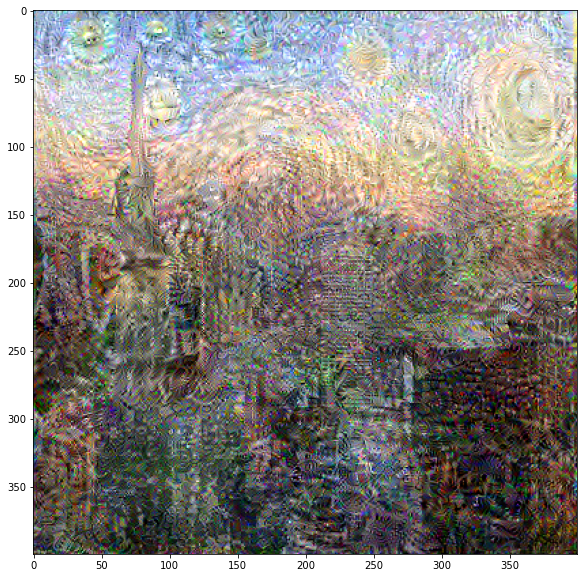

In [17]:
plt.figure(figsize = (20, 10))
plt.imshow(np.squeeze(target_image.read_value(), 0))
plt.show()

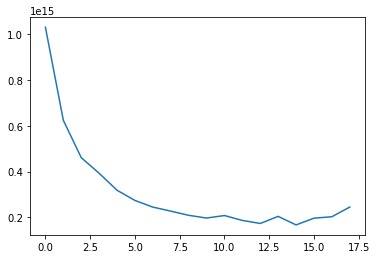

In [18]:
results = sorted(losses.items())
x, y = zip(*results)
plt.plot(x, y)
plt.show()

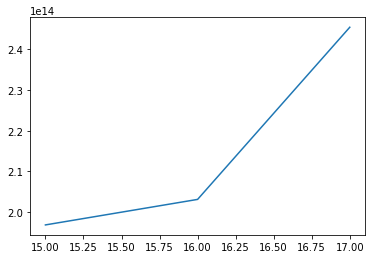

In [19]:
results = sorted(losses.items())
x, y = zip(*results)
plt.plot(x[15:], y[15:])
plt.show()